In [1]:
import matplotlib.pyplot as plt
from numpy import linspace, ones, size, zeros, cos, pi, sin, sqrt, amax, size, mean, arange, square, roots
from numpy.random import normal as noise_gaussian
from pathlib import Path
from math import radians
from os import listdir
from os.path import splitext
import ipywidgets as widgets
from IPython.display import display
from multiprocessing.pool import ThreadPool
from time import process_time
%matplotlib widget

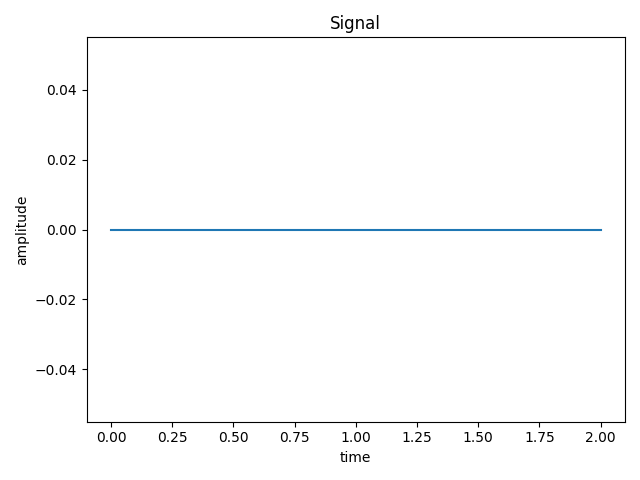

In [2]:
def DFT(yy):
    n = size(yy)
    DFT_r = zeros([n])
    DFT_i = zeros([n])
    y_data = zeros([n])
    for i in range(n):
        for j in range(n):
            a_1 = yy[j] * cos((2 * pi * i * j) / n)
            a_2 = -(yy[j] *sin((2 * pi * i * j) / n))
            DFT_r[i] += a_1
            DFT_i[i] += a_2
        y_data[i] = (sqrt((DFT_r[i] ** 2) + (DFT_i[i] **2))) / n
    return y_data

def BPF(non_filtered):
    yBPF = zeros(size(non_filtered))
    s_p = int(select_theta_pole_zero.get_interact_value())
    r_p = float(select_r_pole_zero.get_interact_value())
    x_p = r_p * cos((s_p * pi) / 360)
    
    for i in range(size(non_filtered)):
        yBPF[i] += 2 * x_p * yBPF[i - 1] - (r_p ** 2) * yBPF[i - 2] + non_filtered[i]
        if i > 2: yBPF[i] += -non_filtered[i - 2]
    
    if amax(yBPF) > 1:
        yBPF = yBPF / amax(yBPF)
        
    return yBPF

def DRV(yBPF):
    yDRV = []
    for i in range(size(yBPF)):
        if i < 2:
            a = 0
        else:
            a = -yBPF[i - 2]
        if i < 1:
            b = 0
        else:
            b = -2 * yBPF[i - 1]
        if i > size(yBPF) - 2:
            c = 0
        else:
            c = 2 * yBPF[i + 1]
        if i > size(yBPF) - 3:
            d = 0
        else:
            d = yBPF[i + 2]
        yDRV += [(a + b + c + d) / 8]
        
    return yDRV

def SQR(yDRV):
    ySQR = list(map(lambda x: x ** 2, yDRV))

    return ySQR

def MVI(ySQR):
    yMVI = []
    WSI = 30
    for i in range(size(ySQR)):
        MAV = 0
        for j in range(WSI):
            if i - (WSI - j) >= 0:
                MAV += ySQR[i - (WSI - j)]
        yMVI += [MAV / WSI]

    spki, npki, th = zeros([size(yMVI)]), zeros([size(yMVI)]), zeros([size(yMVI)])
    for i in range(size(yMVI)):
        spki[i] = 0.125 * max(yMVI) + 0.875 * spki[i - 1]
        npki[i] = 0.125 * max(yMVI) + 0.875 * npki[i - 1]
        th[i] = 0.5 * (npki[i] + 0.25 * (spki[i] - npki[i]))

    return yMVI, th

def Peak(yMVI, th):  # menentukan peak detector
    y_peak = zeros([size(yMVI)])

    HR_data = yMVI
    maxvalue = 0
    n_maxvalue = 0
    status = 0
    for i in range(1, len(HR_data) - 1):
        if HR_data[i] > th[i] and HR_data[i] > HR_data[i - 1] and HR_data[i] > HR_data[i + 1]:
            if HR_data[i] > maxvalue:
                maxvalue = HR_data[i]
                n_maxvalue = i
                status = 1
        if HR_data[i] < th[i]:
            if status == 1:
                y_peak[n_maxvalue] = maxvalue
                status = 0
                maxvalue = 0

    return y_peak

def RR(y_peak):
    R = []
    RtoR = []
    for i in range(size(y_peak)):
        if y_peak[i] != 0:
            R += [i]

    if size(R) <= 1:
        return [0]
    else:
        for i in range(int(size(R) - 1)):
            RtoR += [R[i + 1] - R[i]]
        return RtoR

def Hitung(RtoR):
    Miss_1 = mean(RtoR)
    if Miss_1 == 0:
        Miss_2 = 0
    else:
        Miss_2 = (select_frequency_sampling.get_interact_value() * 60) / Miss_1
    return Miss_1, Miss_2

texts_0 = [[],[]]
texts_1 = []
texts_2 = []
texts_3 = []
texts_4 = []
texts_5 = []
texts_6 = []
texts_7 = []
texts_8 = []
texts_9 = []

######################## File Select 
files = listdir(Path().absolute())
temp = []
for file in files:
    if splitext(file)[1] == ".txt":
        temp.append(file)
files = temp

######################## Widgets File Select
opening_select_signal = widgets.Text(value='Please select signal.', 
                       disabled=True)
select_frequency_sampling = widgets.IntText(
    value=200,
    description='fs:',
    disabled=False
)
select_signal = widgets.Select(
    options=files,
    description='Select File:',
    disabled=False
)
button_select_signal = widgets.Button(description='Select Signal')
def on_button_select_signal_clicked(change):
    with open(select_signal.get_interact_value(), "r") as file:
        text_file = file.readlines()
    try:
        texts_0[1] = [float(x.replace("\n", "").split()[0]) for x in text_file]
        texts_0[0] = arange(len(texts_0[1]))
    except ValueError:
        print("Please select single column data file. File Read Error!")
        return
    with out_0:
        fig_0_ax.set(xlabel="sequence", ylabel="amplitude", title="Signal")
        plot_0.set_data(texts_0[0], texts_0[1])
        fig_0_ax.set_xlim([0, max(texts_0[0])])
        fig_0_ax.set_ylim([min(texts_0[1]), max(texts_0[1])])
button_select_signal.on_click(on_button_select_signal_clicked)
select_r_pole_zero = widgets.FloatSlider(
    value=0.8,
    min=0,
    max=1.0,
    step=0.01,
    description='r:',
    readout=True,
    disabled=False
)
select_theta_pole_zero = widgets.IntSlider(
    value=70,
    min=0,
    max=359,
    step=1,
    description='theta:',
    readout=True,
    disabled=False
)
button_filtering = widgets.Button(description='Filtering Pole Zero')
def on_button_filtering(change):
    global texts_1, texts_2
    texts_1 = BPF(texts_0[1])
    
    with out_0:
        plot_0.set_data(texts_0[0], texts_1)
        fig_0_ax.set_xlim([0, max(texts_0[0])])
        fig_0_ax.set_ylim([min(texts_1), max(texts_1)])
button_filtering.on_click(on_button_filtering)
button_drv = widgets.Button(description='DRV')
def on_button_drv(change):
    global texts_1, texts_2
    texts_2 = DRV(texts_1)
    
    with out_0:
        plot_0.set_data(texts_0[0], texts_2)
        fig_0_ax.set_xlim([0, max(texts_0[0])])
        fig_0_ax.set_ylim([min(texts_2), max(texts_2)])
button_drv.on_click(on_button_drv)
button_sqr = widgets.Button(description='SQR')
def on_button_sqr(change):
    global texts_1, texts_2, texts_3
    texts_3 = SQR(texts_2)
    
    with out_0:
        plot_0.set_data(texts_0[0], texts_3)
        fig_0_ax.set_xlim([0, max(texts_0[0])])
        fig_0_ax.set_ylim([min(texts_3), max(texts_3)])
button_sqr.on_click(on_button_sqr)
button_mvi = widgets.Button(description='MVI')
def on_button_mvi(change):
    global texts_1, texts_2, texts_3, texts_4, texts_5
    texts_4, texts_5 = MVI(texts_3)
    
    
    with out_0:
        plot_0.set_data(texts_0[0], texts_4)
        plot_1.set_data(texts_0[0], texts_5)
        fig_0_ax.set_xlim([0, max(texts_0[0])])
        fig_0_ax.set_ylim([min(texts_3), max(texts_3)])
button_mvi.on_click(on_button_mvi)
button_peak = widgets.Button(description='Peak')
def on_button_peak(change):
    global texts_1, texts_2, texts_3, texts_4, texts_5, texts_6
    texts_6 = Peak(texts_4, texts_5)
    
    with out_0:
        plot_0.set_data(texts_0[0], texts_6)
        plot_1.set_data([0], [0])
        fig_0_ax.set_xlim([0, max(texts_0[0])])
        fig_0_ax.set_ylim([min(texts_6), max(texts_6)])
button_peak.on_click(on_button_peak)
button_rr = widgets.Button(description='RR')
def on_button_rr(change):
    global texts_1, texts_2, texts_3, texts_4, texts_5, texts_6, texts_7
    texts_7 = RR(texts_6)
    
    with out_0:
        plot_0.set_data(arange(len(texts_7)), texts_7)
        plot_1.set_data([0], [0])
        fig_0_ax.set_xlim([0, len(texts_7)])
        fig_0_ax.set_ylim([min(texts_7), max(texts_7)])
button_rr.on_click(on_button_rr)
button_change_sequence_to_time = widgets.Button(description='tachogram')
def on_button_change_sequence_to_time(change):
    global texts_1, texts_2, texts_3, texts_4, texts_5, texts_6, texts_7
    
    with out_0:
        fig_0_ax.set(xlabel="sequence", ylabel="bpm", title="Signal")
        plot_0.set_data(arange(len(texts_7)), [60/(x/200) for x in texts_7])
        plot_1.set_data([0], [0])
        fig_0_ax.set_xlim([0, len(texts_7)])
        fig_0_ax.set_ylim([0, 60/(min(texts_7)/200)])
button_change_sequence_to_time.on_click(on_button_change_sequence_to_time)
button_count_histogram = widgets.Button(description='histogram')
def on_button_count_histogram(change):
    global texts_1, texts_2, texts_3, texts_4, texts_5, texts_6, texts_7, texts_8
    counting_rr = {}
    histogram_rr = zeros(500)
    for i in texts_7:
        if i in counting_rr.keys():
            counting_rr[i] += 1
        counting_rr.setdefault(i, 1)
    for i in counting_rr.keys():
        histogram_rr[i] = counting_rr[i]
        
    with out_0:
        fig_0_ax.set(xlabel="sequence", ylabel="amplitude", title="Signal")
        plot_0.set_data(arange(len(histogram_rr)), histogram_rr)
        plot_1.set_data([0], [0])
        fig_0_ax.set_xlim([0, len(histogram_rr)])
        fig_0_ax.set_ylim([0, max(histogram_rr)])
button_count_histogram.on_click(on_button_count_histogram)
button_change_to_frequency = widgets.Button(description='frequency domain')
def on_button_change_to_frequency(change):
    global texts_1, texts_2, texts_3, texts_4, texts_5, texts_6, texts_7, texts_8
    texts_8 = DFT(texts_7)
    with out_0:
        fig_0_ax.set(xlabel="sequence", ylabel="amplitude", title="Signal")
        plot_0.set_data(arange(len(texts_8)), texts_8)
        plot_1.set_data([0], [0])
        fig_0_ax.set_xlim([0, len(texts_8)])
        fig_0_ax.set_ylim([0, max(texts_8)])
button_change_to_frequency.on_click(on_button_change_to_frequency)
button_poin_care = widgets.Button(description='poin care')
def on_button_poin_care(change):
    global texts_1, texts_2, texts_3, texts_4, texts_5, texts_6, texts_7, texts_8
    a = texts_7
    b = texts_7
    a.pop(0)
    b.pop(-1)
    with out_0:
        fig_0_ax.set(xlabel="amplitude", ylabel="amplitude", title="Signal")
        plot_0.set_data(a, b)
        plot_1.set_data([0], [0])
        fig_0_ax.set_xlim([min(a), max(a)])
        fig_0_ax.set_ylim([min(b), max(b)])
button_poin_care.on_click(on_button_poin_care)
button_rr_mean = widgets.Button(description='RR Mean')
def on_button_rr_mean(change):
    with out_1:
        global texts_1, texts_2, texts_3, texts_4, texts_5, texts_6, texts_7
        rr_mean = mean(texts_7)
        rr_mean = 60/(rr_mean/200)
        print("rr mean : {:.2f} bpm".format(rr_mean))
button_rr_mean.on_click(on_button_rr_mean)
button_sdann = widgets.Button(description='SDANN')
def on_button_sdann(change):
    with out_1:
        global texts_1, texts_2, texts_3, texts_4, texts_5, texts_6, texts_7
        fiveminutesequence = select_frequency_sampling.get_interact_value() * 300
        currentsequence = 0
        lapsequence = 0
        fiveminutearray = []
        temparray = []
        i = 0
        while (currentsequence < fiveminutesequence) or (lapsequence < len(texts_7)):
            try:
                currentsequence += texts_7[i]
                temparray.append(texts_7[i])
                i += 1
            except IndexError:
                fiveminutearray.append(temparray)
                break
                
            if currentsequence >= fiveminutesequence:
                lapsequence += fiveminutesequence
                currentsequence = 0
                fiveminutearray.append(temparray)
                
        fiveminute_mean = []
        for i in fiveminutearray:
            fiveminute_mean.append(mean(i))
        rr_mean = mean(texts_7)
        rr_mean = 60/(rr_mean/200)
        
        sigmadelta = 0
        for i in fiveminute_mean:
            sigmadelta = sigmadelta + square(abs(rr_mean-i))
        sdann = (1/len(texts_7)*sigmadelta)**(1/2)
        print("sdann : {:.3f} bpm".format(sdann))
button_sdann.on_click(on_button_sdann)
button_sdnn = widgets.Button(description='SDNN')
def on_button_sdnn(change):
    with out_1:
        global texts_1, texts_2, texts_3, texts_4, texts_5, texts_6, texts_7
        rr_mean = mean(texts_7)
        rr_mean = 60/(rr_mean/200)
        sigmadelta = 0
        for i in texts_7:
            sigmadelta = sigmadelta + square(abs(60/(i/200)-rr_mean))
        sdnn = (1/(len(texts_7)-1)*sigmadelta)**(1/2)
        print("sdnn : {:.3f} bpm".format(sdnn))
button_sdnn.on_click(on_button_sdnn)
button_rmssd = widgets.Button(description='RMSSD')
def on_button_rmssd(change):
    with out_1:
        global texts_1, texts_2, texts_3, texts_4, texts_5, texts_6, texts_7
        sigmadelta = 0
        for i in range(1, len(texts_7)):
            sigmadelta = sigmadelta + square(abs(60/(texts_7[i]/200) - 60/(texts_7[i-1]/200)))
        rmssd = (1/(len(texts_7)-1)*sigmadelta)**(1/2)
        print("rmssd : {:.3f} bpm".format(rmssd))
button_rmssd.on_click(on_button_rmssd)

button_pnn50 = widgets.Button(description='p50nn')
def on_button_pnn50(change):
    with out_1:
        global texts_1, texts_2, texts_3, texts_4, texts_5, texts_6, texts_7
        nn50_count = 0
        for i in range(1, len(texts_7)):
            if (texts_7[i] - texts_7[i-1]) > 20: #butuh disesuaikan dengan frekuensi sampling 50ms
                nn50_count += 1
        pnn50 = nn50_count/len(texts_7)*100
        print("pnn50 : {:.3f} %".format(pnn50))
button_pnn50.on_click(on_button_pnn50)

button_sdsd = widgets.Button(description='sdsd')
def on_button_sdsd(change):
    with out_1:
        global texts_1, texts_2, texts_3, texts_4, texts_5, texts_6, texts_7
        sigma_rr = 0
        for i in range(1, len(texts_7)):
            sigma_rr += abs(texts_7[i] - texts_7[i-1])
        mean_delta_rr = sigma_rr/(len(texts_7) - 1)
        sdsd = 0
        for i in range(1, len(texts_7)):
            sdsd += (abs(texts_7[i] - texts_7[i-1]) - mean_delta_rr)**2
        sdsd = sdsd/(len(texts_7) - 2)
        sdsd = sdsd**(1/2)
        print("sdsd : {:.3f} ms".format(sdsd*5))
button_sdsd.on_click(on_button_sdsd)


out_0 = widgets.Output()
with out_0:
    try:
        plt.close(fig_0)
    except:
        pass
    fig_0, fig_0_ax = plt.subplots(nrows=1, ncols=1)
    fig_0_ax.set(xlabel="time", ylabel="amplitude", title="Signal")
    plot_0, = fig_0_ax.plot([0,1,2], [0,0,0])
    plot_1, = fig_0_ax.plot([0], [0])
    plot_2, = fig_0_ax.plot([0], [0])
    plt.tight_layout()
out_1 = widgets.Output()
    
vertical_box = widgets.VBox([opening_select_signal,
                            select_frequency_sampling,
                            select_signal, 
                            button_select_signal,
                            out_0,
                            select_r_pole_zero,
                            select_theta_pole_zero,
                            button_filtering,
                            button_drv,
                            button_sqr,
                            button_mvi,
                            button_peak,
                            button_rr,
                            button_change_sequence_to_time,
                            button_change_to_frequency,
                            button_count_histogram,
                            button_poin_care,
                            button_rr_mean,
                            button_sdnn,
                            button_sdann,
                            button_rmssd,
                            button_pnn50,
                            button_sdsd,
                            out_1])
display(vertical_box)